Loading images is working correctly

Resizing is working as expected both labels and images have been checked


## Imports

In [1]:
# Add module files on path
import sys
sys.path.append('./modules')

# Importing
import cv2
import torch
import numpy as np
from model import Model
from scipy import ndimage
from torch.utils.data import DataLoader, random_split
from dataset import MyDecDataset, MySegDataset, MyDataLoader
from visualize import show_labeled_image,show_image_and_seg,show_image_and_probmap
from helpers import xml_to_csv,reverse_normalize,total_variation,to_device,get_predicted_centers,accuracy,to_device

torch.manual_seed(24)

In [2]:
# Choose device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


## Segmentation Dataset

In [3]:
# Create custom dataset
dataset_seg = MySegDataset('./Dataset/segmentation') # or define the w, and the h
print("Size of segmentation dataset ", len(dataset_seg))

Size of segmentation dataset  1192


In [4]:
# Split dataset
train_size = int(0.7 * len(dataset_seg))
test_size = int(0.15 * len(dataset_seg))
validation_size = len(dataset_seg) - (train_size + test_size)

train_seg, validation_seg, test_seg = random_split(dataset_seg, [train_size, validation_size, test_size])

In [5]:
print("Size of segmentation test set", len(test_seg))
print("Size of detection training set:", len(train_seg))
print("Size of detection validation set:", len(validation_seg))

Size of segmentation test set 178
Size of detection training set: 834
Size of detection validation set: 180


Target Shape:  torch.Size([1, 480, 640])
Image Shape:  torch.Size([3, 480, 640])


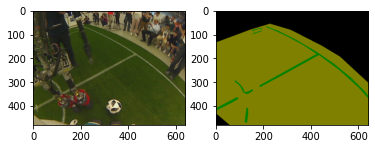

In [6]:
# Create dataloader for segmentation data
test_loader_seg = DataLoader(test_seg, batch_size=16, shuffle=True)
train_loader_seg = DataLoader(train_seg, batch_size=16, shuffle=True)
validation_loader_seg = DataLoader(validation_seg, batch_size=16, shuffle=True)

# Just as a sanity check display the train set
dataset_seg.set_resolution(480,640)
for image, target in train_loader_seg:
    print("Target Shape: ", target[0].shape)
    print("Image Shape: ", image[0].shape)
        
    show_image_and_seg(image[0],target[0])

    break

## Train

In [7]:
def train():
    # Model
    model = Model(device,640,480)
    model = to_device(model, device)

    # Training parameters
    epochs = 150
    learning_rate = 1e-3 # does this make a difference if we are using a scheduler ?
    optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=0.001)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,cycle_momentum=False,base_lr=1e-3,max_lr=1e-2,step_size_up=2000)

    # Current iteration
    iterations = 0

    # Resolution change flags
    set_resolution50 = False
    set_resolution100 = False
    set_resolution150 = False

    for epoch in range(epochs):
        # Segmentation and detection
        # cumulative losses
        cum_loss_seg = 0
        #cum_loss_det = 0

        # Save model every 25 epochs
        #if (epoch % 25 == 0):
        #    torch.save(model.state_dict(), f"/home/user/taouil/NimbRoNet2/models/model_epoch_{epoch}.pt")

        if epoch < 50 and not set_resolution50:
            set_resolution50 = True

            # Freeze encoder layers
            model.freeze_encoder()

            # Set resolution to quarter of orignal size
            #dataset_dt.set_resolution(128,160)
            dataset_seg.set_resolution(128,160)
        elif 50 <= epoch < 100 and not set_resolution100:
            # Unfroze encoder layers
            model.unfreeze_encoder()

            # Set resolution to half original size
            #dataset_dt.set_resolution(256,320)
            dataset_seg.set_resolution(256,320)

            set_resolution100 = True
        elif 100 <= epoch < 150 and not set_resolution150:
            # Set resolution to original size
            #dataset_dt.set_resolution(480,640)
            dataset_seg.set_resolution(480,640)

            set_resolution150 = True

        # Segmentation training
        for batch_idx, batch in enumerate(train_loader_seg):
            batch = to_device(batch,device)

            # Clear gradients
            optimizer.zero_grad()

            # Feed forward and get loss
            loss = model.training_step_segmentation(batch)

            # Compute gradient
            loss.backward()

            # Backprop
            optimizer.step()
            scheduler.step()

            cum_loss_seg += loss.item()/len(batch[0])

        # Validation for segmentation
        accuracy = model.validation_segmentation(validation_loader_seg)
        print('SEGMENTATION -> Epoch: {}. Training Loss: {}. Validation Accuracy: {}\n'.format(epoch, cum_loss_seg, accuracy))


In [8]:
# train()
#torch.save(model.state_dict(), f"/home/user/shoeb/NimbRoNet2/models/segmentation_150_0.38_97.pt")

Accuracy {'Total': 97.33406484082397, 'Field': 98.62621441963525, 'Lines': 83.68075363480781, 'Background': 96.46527864399565}
IOU {'Field': 0.9590024365148484, 'Lines': 0.7399790036266463, 'Background': 0.9536178971503665, 'Total': 0.884199779097287}


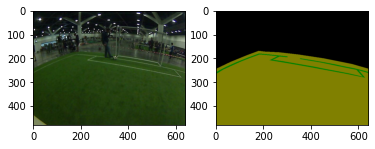

Model Result


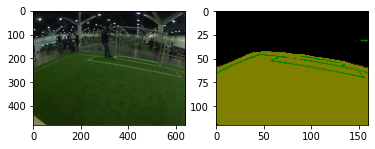

acc 97.35514322916666
acc_field 98.8279737607717
acc_lines 82.01039861351819
acc_background 96.57850289913114
iou 0.8813669954248367
iou_field 0.9566025109082635
iou_lines 0.7272727272727273
iou_background 0.9602257480935192


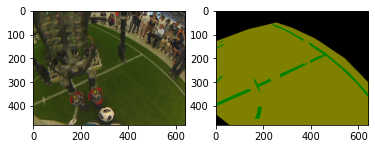

Model Result


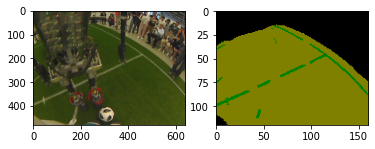

acc 97.7626953125
acc_field 98.0169658520174
acc_lines 81.0515873015873
acc_background 99.69313387034906
iou 0.8880341556417696
iou_field 0.9674800990540527
iou_lines 0.7300158086466424
iou_background 0.966606559224614


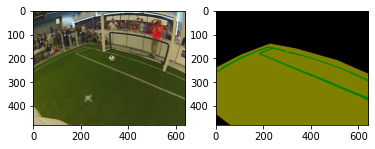

Model Result


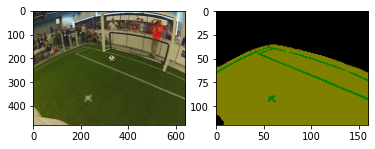

acc 97.98763020833333
acc_field 98.73328421151645
acc_lines 89.35397553516819
acc_background 97.4908659549229
iou 0.8970631242395917
iou_field 0.9683515109270573
iou_lines 0.7522123893805309
iou_background 0.9706254724111867


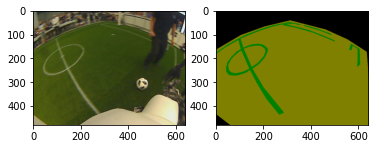

Model Result


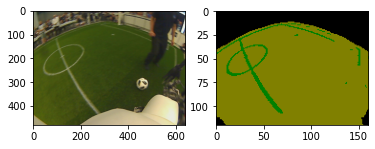

acc 97.97330729166667
acc_field 98.91601206544075
acc_lines 82.38953065675742
acc_background 98.11031084154662
iou 0.8985117931474935
iou_field 0.9681704195858432
iou_lines 0.7554814814814815
iou_background 0.9718834783751561


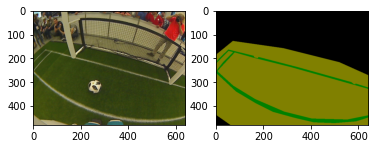

Model Result


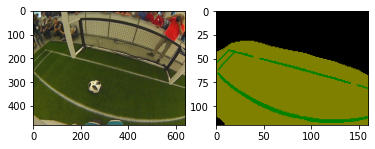

acc 96.77278645833334
acc_field 98.4360625574977
acc_lines 80.77280013498692
acc_background 95.81132239676255
iou 0.8717955027686096
iou_field 0.9475846248232815
iou_lines 0.7220755713100535
iou_background 0.9457263121724938


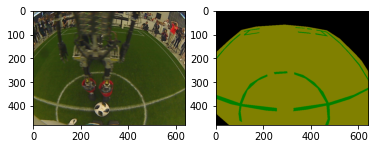

Model Result


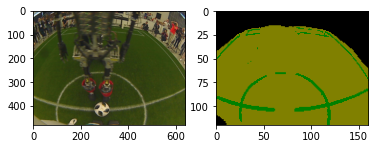

acc 97.80794270833333
acc_field 98.14845574369546
acc_lines 82.14143346886709
acc_background 99.21745606527128
iou 0.8866784700239045
iou_field 0.9676571026736474
iou_lines 0.7228146485197138
iou_background 0.9695636588783524


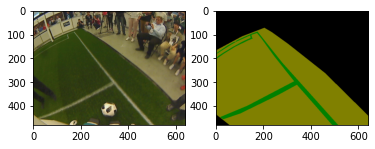

Model Result


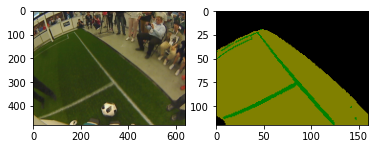

acc 97.0146484375
acc_field 99.15363580853267
acc_lines 83.8796992481203
acc_background 94.51832124161999
iou 0.8777342631840238
iou_field 0.9536993059492255
iou_lines 0.7371156726279623
iou_background 0.9423878109748839


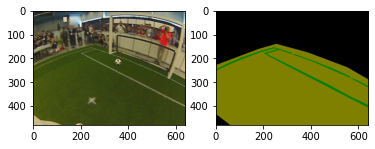

Model Result


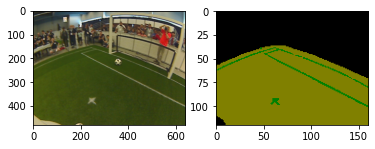

acc 95.11686197916667
acc_field 99.07131788131153
acc_lines 80.15579746329772
acc_background 90.36615078994508
iou 0.845247504717987
iou_field 0.9233150985251105
iou_lines 0.7139299057107277
iou_background 0.8984975099181227


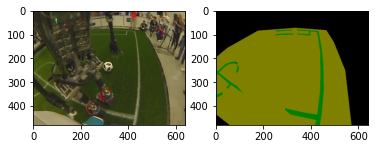

Model Result


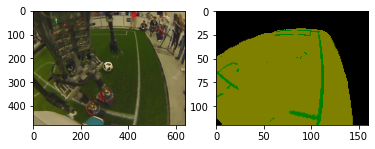

acc 98.1630859375
acc_field 98.46715912157772
acc_lines 85.52856920442161
acc_background 99.23940255441931
iou 0.9034323130852759
iou_field 0.9721795940924813
iou_lines 0.7610834026045996
iou_background 0.9770339425587468


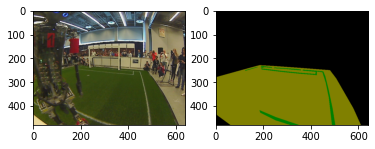

Model Result


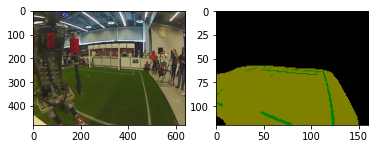

acc 98.06315104166666
acc_field 98.77282657551716
acc_lines 85.92994656941735
acc_background 98.13307710785492
iou 0.9041167987033744
iou_field 0.9695467930762048
iou_lines 0.7709046640797382
iou_background 0.97189893895418


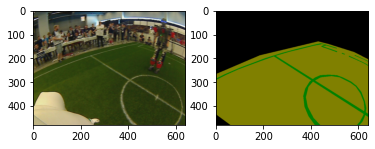

Model Result


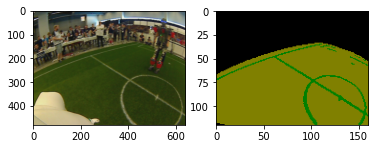

acc 98.12044270833333
acc_field 98.5090128326759
acc_lines 85.83197459881575
acc_background 98.80663748858592
iou 0.8986061588643551
iou_field 0.9715839136387365
iou_lines 0.7494380338678256
iou_background 0.9747965290865036


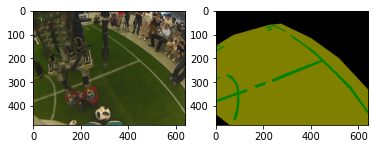

Model Result


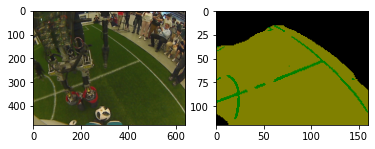

acc 96.94791666666667
acc_field 96.613698630137
acc_lines 85.09955041746949
acc_background 99.86269539501478
iou 0.8800817424950133
iou_field 0.9579137993480623
iou_lines 0.7562785388127854
iou_background 0.9260528893241919


In [9]:
model = Model(device,640,480)
model = to_device(model, device)

model.load_state_dict(torch.load("/home/user/shoeb/NimbRoNet2/models/segmentation_150_0.38_97.pt"), strict=False)
accuracy,iou = model.validation_segmentation(test_loader_seg)
print('Accuracy',accuracy)
print('IOU',iou)
correct = 0
total = 0
correct_field = 0
total_field = 0
correct_lines = 0
total_lines = 0
correct_background = 0
total_background = 0
for image, target in test_loader_seg:    
    show_image_and_seg(image[0],target[0])
    image_gpu = to_device(image,device)
    output = model(image_gpu,head="segmentation")
    
    
    softmax = torch.nn.LogSoftmax(dim=1) # wait for hafez reply if it is needed or not
    softmax_output = softmax(output)
            
    # Get predictions from the maximum value
    _, predicted = torch.max(softmax_output, 1)
    
    predicted = predicted.detach()
    print('Model Result')
    show_image_and_seg(image[0],predicted.cpu())
    
    downsampled_target = torch.nn.functional.interpolate(target,scale_factor=0.25,
                                                                 mode="nearest",
                                                                 recompute_scale_factor=False)
    downsampled_target = torch.squeeze(downsampled_target,dim=1) #(batch_size,1,H,W) -> (batch_size,H,W)
    downsampled_target = downsampled_target.type(torch.LongTensor) # convert the target from float to int
    
     # Total correct predictions
    c_base = predicted.cpu() == downsampled_target.cpu()
    correct = (predicted.cpu() == downsampled_target.cpu()).sum().item()
    field_mask = downsampled_target.cpu()==1
    correct_field = (np.logical_and(c_base,field_mask)).sum().item()
    line_mask = downsampled_target.cpu()==2
    correct_lines =(np.logical_and(c_base,line_mask)).sum().item()
    background_mask = downsampled_target.cpu()==0
    correct_background =(np.logical_and(c_base,background_mask)).sum().item()

    # Total number of labels
    total = (downsampled_target.size(0)*downsampled_target.size(1)*downsampled_target.size(2))
    total_field = field_mask.sum().item()
    total_lines =line_mask.sum().item()
    total_background =background_mask.sum().item()
    
    # IOU true positive / (true positive + false positive + false negative)
    tp_field = (np.logical_and(c_base,field_mask)).sum().item()
    pred_field = predicted.cpu() == 1
    fp_field = (np.logical_and(pred_field ,np.logical_not(field_mask))).sum().item()
    fn_field = (np.logical_and(np.logical_not(np.logical_and(c_base,field_mask)),field_mask)).sum().item()
    iou_field = tp_field / (tp_field+fp_field+fn_field)
    tn_field = (np.logical_and(np.logical_not(pred_field),np.logical_not(field_mask))).sum().item()# Just as a sanity check
    
    
    tp_lines = (np.logical_and(c_base,line_mask)).sum().item()
    pred_lines = predicted.cpu() == 2
    fp_lines = (np.logical_and(pred_lines ,np.logical_not(line_mask))).sum().item()
    fn_lines = (np.logical_and(np.logical_not(np.logical_and(c_base,line_mask)),line_mask)).sum().item()
    iou_lines = tp_lines / (tp_lines+fp_lines+fn_lines)
    tn_lines = (np.logical_and(np.logical_not(pred_lines),np.logical_not(line_mask))).sum().item()# Just as a sanity check

    
    tp_background = (np.logical_and(c_base,background_mask)).sum().item()
    pred_background = predicted.cpu() == 0
    fp_background = (np.logical_and(pred_background ,np.logical_not(background_mask))).sum().item()
    fn_background = (np.logical_and(np.logical_not(np.logical_and(c_base,background_mask)),background_mask)).sum().item()
    iou_background = tp_background / (tp_background+fp_background+fn_background)
    tn_background = (np.logical_and(np.logical_not(pred_background),np.logical_not(background_mask))).sum().item()# Just as a sanity check

    
    
    
    print('acc',100 * (correct / total))
    print('acc_field',100 * (correct_field / total_field))
    print('acc_lines',100 * (correct_lines / total_lines))
    print('acc_background',100 * (correct_background / total_background))
    
    print('iou',(iou_lines+iou_field+iou_background)/3)
    print('iou_field',iou_field)
    print('iou_lines',iou_lines)
    print('iou_background',iou_background)
    
    